> This notebook is adapted from the official implementation: https://github.com/ermongroup/ncsn

# A Noise Conditional Score Network (NCSN) applied to MNIST

This notebook demonstrates how to implement a Noise Conditional Score Network (NCSN) from scratch, specifically applied to the MNIST dataset. It is part of the hands-on section of the Diffusion Models Minicourse at SBBD 2025.

NCSNs are a class of generative models that learn to estimate score functions (gradients of the log data density) at multiple noise levels, allowing us to generate new data samples using annealed Langevin dynamics.

## Import dependencies
We start by importing all necessary libraries for data handling, model building, training, and visualization. This includes PyTorch for deep learning, torchvision for datasets and transforms, and matplotlib for plotting.

In [22]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import MNIST
from torchvision import transforms
from tqdm import tqdm
from models.ncsn import CondRefineNetDilated
from torchvision.utils import make_grid, save_image

In [2]:
load_model = True

Variable that controls if the model will be retrained or not:

In [3]:
# Parameters
epochs = 100
learning_rate = 0.001
batch_size = 128
device = 'cuda'

# Model parameters
sigma_begin = 1.0
sigma_end = 0.01
num_classes = 10  # Number of noise levels
ngf = 64  # Number of generator features

# Training parameters
anneal_power = 2.0
weight_decay = 0.0
beta1 = 0.9
amsgrad = False

# Data parameters
image_size = 28
channels = 1

## Implementation of the Conditional RefineNet

The Conditional RefineNet is a neural network architecture designed to estimate score functions at different noise levels. Unlike the U-Net used in DDPMs, the RefineNet uses dilated convolutions and multi-scale feature refinement to capture different levels of detail in the data.

The network takes as input a noisy image and a noise level (class), and outputs the estimated score function (gradient of log-likelihood) for that specific noise level. This conditioning on noise levels is crucial for the annealed Langevin dynamics sampling procedure.

Architecture:
The model uses a series of dilated convolutional blocks that can capture both local and global dependencies in the data. The noise level conditioning is achieved through class embeddings that are injected into the network at multiple scales.

The code of the Conditional RefineNet implementation is available on file [models/ncsn.py](./models/ncsn.py).

## Noise schedule

The noise schedule in NCSN defines the different noise levels σ_i that the model will learn to handle. Unlike DDPMs which use a forward diffusion process, NCSNs directly define a geometric sequence of noise levels from high to low values. This schedule is crucial for effective training and sampling.

## Training and model parameters

Here we define the key hyperparameters for training the NCSN, including noise levels, learning rate, batch size, and model parameters. The noise schedule is crucial as it determines the range of noise levels the model will learn to denoise.

In [4]:
tran_transform = test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

In [13]:
train_dataset = MNIST(
    "./data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])
)
test_dataset = MNIST(
    "./data",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])
)

# Concatenate training and test data
dataset = ConcatDataset([train_dataset, test_dataset])

# Create data loader
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1
)

## Load the data

We load the MNIST dataset, which consists of handwritten digit images. Both the training and test sets are combined to maximize the available data. Images are resized to 28x28 and normalized to [0, 1] range. A data loader is created to efficiently batch and shuffle the data during training. An example image is displayed to verify the data loading process.

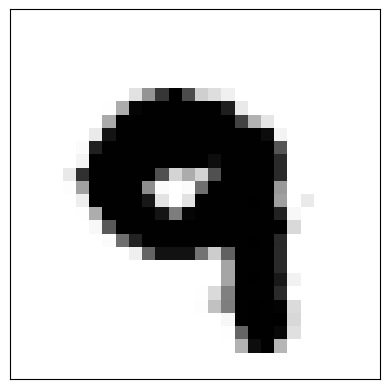

In [14]:
# Show example image
X_example = next(iter(dataloader))[0][0]
plt.imshow(X_example.detach().cpu().numpy().squeeze(), cmap='Greys')
plt.xticks([])
plt.yticks([])
plt.show()

In [15]:
model = CondRefineNetDilated(
    logit_transform=False,
    ngf=ngf,
    num_classes=num_classes,
    image_size=image_size,
    channels=channels
).to(device)

## Instantiate the model

We instantiate the Conditional RefineNet model, which will be trained to estimate the score function for different noise levels. The model is moved to the selected device (CPU or GPU).

In [16]:
optimizer = optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
    betas=(beta1, 0.999),
    amsgrad=amsgrad,
)

## Optimizer and loss function

We use the Adam optimizer to train the model. The loss function is the annealed denoising score matching (DSM) objective, which encourages the model to estimate the score function for each noise level.

In [17]:
sigmas = torch.tensor(
    np.exp(np.linspace(np.log(sigma_begin), np.log(sigma_end), num_classes))
).float().to(device)
print('Noise levels (sigmas):', sigmas.cpu().numpy())

Noise levels (sigmas): [1.         0.59948426 0.35938138 0.21544346 0.12915497 0.07742637
 0.04641589 0.02782559 0.01668101 0.01      ]


In [18]:
def anneal_dsm_score_estimation(scorenet, samples, labels, sigmas, anneal_power=2.):
    used_sigmas = sigmas[labels].view(samples.shape[0], *([1] * len(samples.shape[1:])))
    perturbed_samples = samples + torch.randn_like(samples) * used_sigmas
    target = - 1 / (used_sigmas ** 2) * (perturbed_samples - samples)
    scores = scorenet(perturbed_samples, labels)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1) * used_sigmas.squeeze() ** anneal_power

    return loss.mean(dim=0)

## Annealed denoising score matching (DSM) loss

The DSM loss is used to train the score network. For each batch, we sample a noise level, perturb the data, and train the model to predict the score (gradient of log-likelihood) for that noise level. The loss is averaged over the batch.

In [19]:
if load_model:
    model.load_state_dict(torch.load('./weights/ncsn_100epochs.pickle', map_location=device))
else:
    for epoch in tqdm(range(epochs)):
        for i, (X, y) in enumerate(dataloader):
            model.train()
            X = X.to(device)
            X = X / 256. * 255. + torch.rand_like(X) / 256.

            labels = torch.randint(0, len(sigmas), (X.shape[0],), device=X.device)
            loss = anneal_dsm_score_estimation(model, X, labels, sigmas, anneal_power)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

## Train the model

This section covers the training loop for the NCSN. The model learns to predict the score function for images perturbed by different noise levels. The optimizer updates the model weights to minimize the DSM loss. Periodic checkpoints can be saved for later use.

In [20]:
def anneal_Langevin_dynamics(x_mod, scorenet, sigmas, n_steps_each=100, step_lr=0.00002):
    images = []

    with torch.no_grad():
        for c, sigma in tqdm(enumerate(sigmas), total=len(sigmas), desc='annealed Langevin dynamics sampling'):
            labels = torch.ones(x_mod.shape[0], device=x_mod.device) * c
            labels = labels.long()
            step_size = step_lr * (sigma / sigmas[-1]) ** 2
            for s in range(n_steps_each):
                noise = torch.randn_like(x_mod) * torch.sqrt(step_size * 2)
                grad = scorenet(x_mod, labels)
                x_mod = x_mod + step_size * grad + noise
            images.append(torch.clamp(x_mod, 0.0, 1.0).to('cpu'))

        return images

## Sampling with annealed Langevin dynamics

After training, we use annealed Langevin dynamics to generate new MNIST-like images from pure noise. The sampling function iteratively denoises a random image, reversing the noise process using the learned score network. Intermediate and final results are displayed to visualize the generative process.

In [21]:
grid_size = 3
samples = torch.rand(grid_size ** 2, 1, 28, 28, device=device)
all_samples = anneal_Langevin_dynamics(samples, model, sigmas, n_steps_each=100, step_lr=0.00002)

annealed Langevin dynamics sampling:   0%|          | 0/10 [00:00<?, ?it/s]

annealed Langevin dynamics sampling: 100%|██████████| 10/10 [00:35<00:00,  3.57s/it]


## Generate and save images

We use the trained NCSN to generate new samples. The images are saved in a grid format for visualization. This allows us to inspect the quality and diversity of the generated samples.

In [24]:
for i, sample in enumerate(tqdm(all_samples, total=len(all_samples), desc='saving images')):
    sample = sample.view(grid_size ** 2, channels, image_size, image_size)
    image_grid = make_grid(sample, nrow=grid_size)
    save_image(image_grid, f'./samples/image_{i}.png')

saving images: 100%|██████████| 10/10 [00:00<00:00, 545.38it/s]
